## Задания

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

-----

In [38]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier, uplift_tree_string, uplift_tree_plot

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation

from catboost import CatBoostClassifier

import xgboost as xgb

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

-----
Задания 1-3:

In [2]:
data_path_name = 'data'
os.system("kaggle datasets download davinwijaya/customer-retention --unzip -p " + data_path_name)

DATA_PATH = Path('./' + data_path_name)
DATASET = DATA_PATH / 'data.csv'

In [3]:
df = pd.read_csv(DATASET)
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.treatment = (df.treatment != 'No Offer').astype('int64')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df.target,
                                                    test_size=0.2,
                                                    random_state=33,
                                                    stratify=df['treatment'])

------
Задание 4:

Рассмотрим типы данных датасета и разделим их на логические части:

In [5]:
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

Все значения присутствуют. Обрабатывать пропуски не нужно.

In [6]:
X_train.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
dtype: object

In [7]:
features_num = X_train.dtypes[df.dtypes != 'object'].index
features_cat = X_train.dtypes[df.dtypes == 'object'].index

In [8]:
df[features_num].describe()

,recency,history,used_discount,used_bogo,is_referral,treatment
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


Как видно, из списка числовых признаков выделяются биномиальные величины и непрерывные (или подобные им, как, например, `recency`). Разделим и их:

In [9]:
features_cont = ['recency', 'history']
features_binom = list(set(features_num) - set(features_cont))

Рассмотрение признаков ***со значечниями 0 и 1*** пока нет смысла делать столь тщательно, можно лишь оценить, нет ли колонок, принимающих всего лишь одно значение:

In [10]:
X_train[features_binom].var()

is_referral      0.250002
used_discount    0.247452
treatment        0.222085
used_bogo        0.247520
dtype: float64

Во всех таких колонках содержатся полезные данные.

----

Далее можно рассмотреть признаки с ***непрерывными*** значениями:

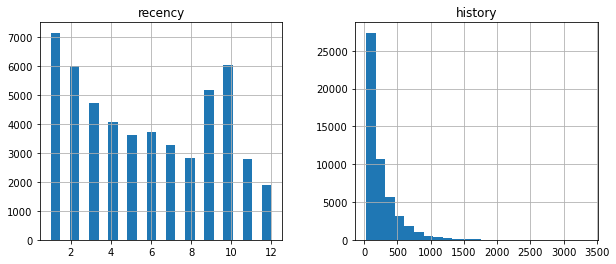

In [11]:
X_train[features_cont].hist(figsize=(10, 4), bins=23)
plt.show()

Как видно, распределение псевдонепрерывного признака `recency` имеет явный рост на значениях 9 и 10, что может говорить о том, что в этот период проводилась активная рекламная кампания, можно попробовать выделить этот период в отдельный признак, если частота оттока в эти моменты была отличная от других:

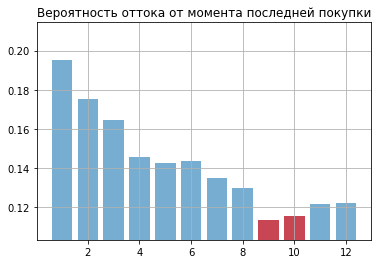

In [12]:
rec_tar_dict = dict()
for val in X_train['recency'].value_counts().sort_index().index:
    rec_tar_dict[val] = y_train[X_train["recency"] == val].mean()

plt.bar(rec_tar_dict.keys(), rec_tar_dict.values(), alpha=0.6)
plt.bar([9, 10], [rec_tar_dict[9], rec_tar_dict[10]], color='r', alpha=0.6)
plt.ylim([min(rec_tar_dict.values()) / 1.1, max(rec_tar_dict.values()) * 1.1])
plt.title('Вероятность оттока от момента последней покупки')
plt.grid()
plt.show()

Действительно, даже на первый взгляд разница отчетливо видна.

----

Далее рассмотрим признак `history`, распределение которого на первый взгляд ничего интересного не показывает.<br>
Как видно, график имеет достаточно длинный хвост и хочется иметь возможность его или убрать, или корректно обработать. Для выбора решения построим график распределения разницы средней вероятности оттока для "левой" и "правой" частей выборки, разбитой по определенному порогу (получим некий аналог критерия Джини или энтропии): 

In [13]:
min_history, max_history = X_train['history'].min(), X_train['history'].max()
threshold_history = dict()

for i, q in enumerate(np.linspace(0, 1, 50)):
    thr = X_train['history'].quantile(q)
    bt = y_train[X_train['history'] > thr].mean()
    le = y_train[~(X_train['history'] > thr)].mean()
    threshold_history[thr] = bt - le

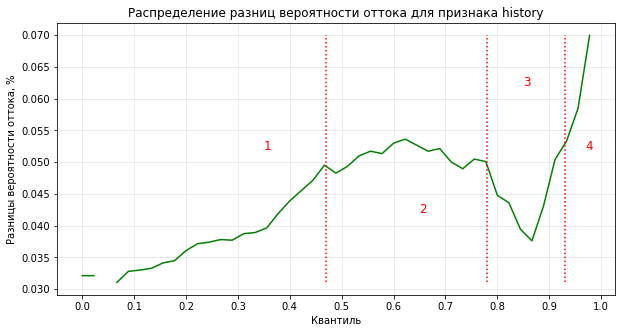

In [14]:
min_ = min(threshold_history.values())
max_ = max(threshold_history.values())
plt.figure(figsize=[10, 5])
plt.plot(np.linspace(0, 1, len(threshold_history)), threshold_history.values(), color='g')
plt.text(0.35, 0.052, '1', size='large', color='r')
plt.plot([0.47, 0.47], [min_, max_], color='r', linestyle=':')
plt.text(0.65, 0.042, '2', size='large', color='r')
plt.plot([0.78, 0.78], [min_, max_], color='r', linestyle=':')
plt.text(0.85, 0.062, '3', size='large', color='r')
plt.plot([0.93, 0.93], [min_, max_], color='r', linestyle=':')
plt.text(0.97, 0.052, '4', size='large', color='r')
plt.xticks(np.linspace(0, 1, 11))
plt.grid(alpha=0.3)
plt.title('Распределение разниц вероятности оттока для признака history')
plt.xlabel('Квантиль')
plt.ylabel('Разницы вероятности оттока, %')
plt.show()

Здесь можно выделить 4 части, на которых:
1. происходит рост разницы
2. наблюдается плато достаточно высоких значений
3. разница между группами клиентов снижается. Таким образом такие клиенты по сравнению с прошлой группой будут дольше находиться у нас и не попадут в отток
4. разница стремится к наибольшим значениям (таких клиентов и можно назвать китами, а то, что их вероятность оттока выше остальных может говорить не о самых удачных подходах к группе. Возможно, стоит пересмотреть отношение к ним в общем и целом &#128578;)

Таким образом при имеющемся разнообразии на графике придется отказаться от идеи удаления "выбросов" и предлагается сделать 4 новых биномиальных признака принадлежности к каждой группе.

----

Рассмотрим ***категориальные*** признаки и их вклад в целевую переменную:

In [15]:
print(f'Feature  Value\t\tCount\t%1class for target ({round(y_train.mean(), 4)} default)')
for column in features_cat:
    print('------')
    print(column)
    for val in X_train[column].value_counts().sort_values(ascending=False).index:
        print('\t ', end='')
        print(f'{val:12}{(X_train[column] == val).sum():8}{round(y_train[X_train[column] == val].mean(), 4):10}')

Feature  Value		Count	%1class for target (0.1468 default)
------
zip_code
	 Surburban      23002    0.1401
	 Urban          20574    0.1396
	 Rural           7624    0.1861
------
channel
	 Web            22542    0.1595
	 Phone          22528    0.1276
	 Multichannel    6130    0.1705


1. Для `zip_code` можно выделить две группы: немногочисленные пользователи со значением признака равным `Rural` и повышенной вероятностью оттока и многочисленная остальная часть с вероятностью оттока ниже. Предлагается создать биномиальный признак (взамен текущего) на равенство значению `Rural`.
2. Для `channel` подобных явных закономерностей не наблюдается, поэтому можно перевести признак в 3 новых на равенство каждого из значений.

----

Подготовим пайплайны:

In [16]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

class FeatureCreating(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.__fitted = False
    
    def fit(self, X, y=None):
        self.__history_1 = X['history'].quantile(0.47)
        self.__history_2 = X['history'].quantile(0.78)
        self.__history_3 = X['history'].quantile(0.93)
        
        self.__fitted = True
        
        return self
    
    def transform(self, X, y=None):
        if self.__fitted:
            X = X.copy()
            X['recency_9-10'] = X['recency'].isin([9, 10]).astype('int64')
            
            X['history_1'] = (X['history'] < self.__history_1).astype('int64')
            X['history_2'] = ((X['history'] >= self.__history_1) & (X['history'] < self.__history_2)).astype('int64')
            X['history_3'] = ((X['history'] >= self.__history_2) & (X['history'] < self.__history_3)).astype('int64')
            X['history_4'] = (X['history'] >= self.__history_3).astype('int64')
            
            X['zip_code_is_Rural'] = (X['zip_code'] == 'Rural').astype('int64')
            X.drop(columns='zip_code', inplace=True)
            
            X = pd.get_dummies(X, columns=['channel'])
            
            return X
        else:
            raise BaseException('Object not fitted.')

            
def proba_to_cls(y_proba, thr):
    return (y_proba > thr).astype('int')

In [17]:
pipeline = Pipeline([('transform', FeatureCreating()),
                     ('cls', xgb.XGBClassifier(eval_metric='logloss',
                                               use_label_encoder=False,
                                               max_depth=4,
                                               learning_rate=0.1,
                                               n_estimators=300))])

pipeline.fit(X_train, y_train)
pred_proba_train = pipeline.predict_proba(X_train)[:, 1]
pred_proba_test = pipeline.predict_proba(X_test)[:, 1]

Найдем оптимальные пороги и проверим, не сильно ли переобучилась модель:

In [18]:
precision, recall, thresholds = precision_recall_curve(y_train, pred_proba_train)

fscore = 2*(precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.181533, F-Score=0.351, Precision=0.268, Recall=0.508


In [19]:
thr = thresholds[ix]

pred_train = proba_to_cls(pred_proba_train, thr)
pred_test = proba_to_cls(pred_proba_test, thr)

f1_score(y_test, pred_test)

0.2841510122195878

-----
Задание 5:

In [40]:
pipeline_sm = Pipeline([('transform', FeatureCreating()),
                        ('sm', SoloModel(xgb.XGBClassifier(eval_metric='logloss',
                                                           use_label_encoder=False,
                                                           max_depth=4,
                                                           learning_rate=0.1,
                                                           n_estimators=300)))])

pipeline_tm = Pipeline([('transform', FeatureCreating()),
                        ('tm', TwoModels(xgb.XGBClassifier(eval_metric='logloss',
                                                           use_label_encoder=False,
                                                           max_depth=4,
                                                           learning_rate=0.1,
                                                           n_estimators=300),
                                        xgb.XGBClassifier(eval_metric='logloss',
                                                           use_label_encoder=False,
                                                           max_depth=4,
                                                           learning_rate=0.1,
                                                           n_estimators=300)))])

pipeline_tr = Pipeline([('transform', FeatureCreating()),
                        ('tr', ClassTransformation(xgb.XGBClassifier(eval_metric='logloss',
                                                                     use_label_encoder=False,
                                                                     max_depth=4,
                                                                     learning_rate=0.1,
                                                                     n_estimators=300)))])

pipeline_sm.fit(X_train, y_train, sm__treatment=X_train['treatment'])
pipeline_tm.fit(X_train, y_train, tm__treatment=X_train['treatment'])
pipeline_tr.fit(X_train, y_train, tr__treatment=X_train['treatment'])

uplift_sm = pipeline_sm.predict(X_test)
uplift_tm = pipeline_tm.predict(X_test)
uplift_tr = pipeline_tr.predict(X_test)

In [26]:
res = {'approach': ['SoloModel', 'TwoModels', 'ClassTransformation']}

for i in range(1, 4):
    sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=i / 10)
    tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=i / 10)
    tr_score = uplift_at_k(y_true=y_test, uplift=uplift_tr, treatment=X_test['treatment'], strategy='by_group', k=i / 10)
    
    res[f'uplift@{i * 10}%'] = [sm_score, tm_score, tr_score]

In [28]:
pd.DataFrame(res)

,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.117096,0.092343,0.078251
1,TwoModels,0.100658,0.091760,0.086860
2,ClassTransformation,0.233253,0.195582,0.165842


Видно, что прямая оценка с помощью одной/двух моделей не дали такого хорошего результата, как трансформация целевой переменной.

----
Задание 8:

In [75]:
df_test = X_test.copy()
df_test['pred_uplift'] = uplift_sm
df_test['target'] = y_test

df_test = df_test.sort_values('pred_uplift', ascending=False)
df_test
df_test['q_uplift'] = pd.qcut(df_test['pred_uplift'], 10)

df_test[['q_uplift', 'target']].groupby('q_uplift').mean().reset_index()

,q_uplift,target
0,"(-0.0712, 0.0269]",0.164844
1,"(0.0269, 0.0335]",0.133594
2,"(0.0335, 0.0393]",0.115445
3,"(0.0393, 0.0464]",0.121875
4,"(0.0464, 0.0563]",0.140063
5,"(0.0563, 0.0655]",0.141406
6,"(0.0655, 0.0728]",0.135937
7,"(0.0728, 0.0806]",0.144860
8,"(0.0806, 0.0973]",0.174765
9,"(0.0973, 0.31]",0.195312


В общем можно видеть общую зависимость, что при росте `uplift` показателя средняя вероятность оттока повышается, что косвенно также можно говорить об успехе расчета.

----
Для заданий 7, 9 установить `causalml` удалось, однако при пострении распределения дерева была ошибка наподобие `GraphViz's Executables not found`, хотя эта доп. библиотека вроде как установлена. Если встречались с этим, буду рад узнать, как можно это устранить (установку через `pip/conda install graphviz/python-graphviz` делать пытался)